## GET DATA AND IMPORT MODEL

In [2]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [18]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import viterbi
import pathlib
from tqdm.notebook import tqdm
import os
from viterbi import calculate_emission_matrix
import h5py

In [3]:
os.getcwd()

'/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/VITERBI'

In [4]:
# We need to get the data from the HDF5 file in '/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/TODOS_resampled_5ms_VD-predictions_20231116.hdf5'
hdf5_file = h5py.File('/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/TODOS_resampled_5ms_VD-predictions_20231116.hdf5', 'r')

In [5]:
# Then we need to stack the datasets contained in each group into a single dataframe
# The columns of each h5py dataset corresponds to the following indexes:
"""
Contenu des colonnes :
0   :   timeframes
1   :   creaky_voice_decision
2   :   bana_resampled
3   :   opensmile_resampled
4   :   pefac_resampled
5   :   praat_ac_resampled
6   :   praat_cc_resampled
7   :   praat_shs_resampled
8   :   pyin_resampled
9   :   rapt_resampled
10  :   srh_resampled
11  :   straight_resampled
12  :   swipe_resampled
13  :   swipep_resampled
14  :   yaapt_resampled
15  :   yin_resampled
16  :   hnr_resampled
17  :   cpps_resampled
18  :   praat_intensity_resampled
19  :   praat_se_resampled
20  :   mfcc_01
21  :   mfcc_02
22  :   mfcc_03
23  :   mfcc_04
24  :   mfcc_05
25  :   mfcc_06
26  :   mfcc_07
27  :   mfcc_08
28  :   mfcc_09
29  :   mfcc_10
30  :   mfcc_11
31  :   mfcc_12
32  :   mfcc_13
33  :   mfcc_14
34  :   mfcc_15
35  :   mfcc_16
36  :   mfcc_17
37  :   mfcc_18
38  :   mfcc_19
39  :   mfcc_20
40  :   group_index / file_index
41  :   model_pred_all
42  :   model_pred_mfcc
43  :   model_pred_f0
"""

# Create a dictionary with the pairs column_name:column_index
index_dict = {'timeframes': 0,
              'creaky_voice_decision': 1,
                'bana': 2,
                'opensmile': 3,
                'pefac': 4,
                'praat_ac': 5,
                'praat_cc': 6,
                'praat_shs': 7,
                'pyin': 8,
                'rapt': 9,
                'srh': 10,
                'straight': 11,
                'swipe': 12,
                'swipep': 13,
                'yaapt': 14, 
                'yin': 15,
                'hnr': 16,
                'cpps': 17,
                'intensity': 18,
                'se': 19,
                'mfcc_01': 20,
                'mfcc_02': 21,
                'mfcc_03': 22,
                'mfcc_04': 23,
                'mfcc_05': 24,
                'mfcc_06': 25,
                'mfcc_07': 26,
                'mfcc_08': 27,
                'mfcc_09': 28,
                'mfcc_10': 29,
                'mfcc_11': 30,
                'mfcc_12': 31,
                'mfcc_13': 32,
                'mfcc_14': 33,
                'mfcc_15': 34,
                'mfcc_16': 35,
                'mfcc_17': 36,
                'mfcc_18': 37,
                'mfcc_19': 38,
                'mfcc_20': 39,
                'group_index': 40,
                'model_pred_all': 41,
                'model_pred_mfcc': 42,
                'model_pred_f0': 43}

# Create a function that resturns a list of indexes for a given list of column names
def get_index_list(column_list):
    index_list = []
    for column in column_list:
        index_list.append(index_dict[column])
    return index_list

In [6]:
get_index_list(['timeframes', 'creaky_voice_decision', 'bana_resampled'])

KeyError: 'bana_resampled'

## GROUP FILES

In [7]:
# Select PDAs to be tested
pdas = ['pefac', 'rapt', 'swipe', 'swipep', 'srh', 'yin']

get_index_list(pdas)

[4, 9, 12, 13, 10, 15]

In [8]:
# From hdf5_file get 'bfamcv27_334_331697_0_333495_0_NOSSA' dataset

# Get the dataset
dataset = hdf5_file['bfamcv27_334_331697_0_333495_0_NOSSA']

# Check if in column 41 there is any NaN value
dataset[:, 41].shape
np.isnan(dataset[:, 41]).any()

True

In [9]:
index_dict['model_pred_all']

41

In [10]:
# Create observations dict containing 
observations_dict = {}

# Iterate through each file in the HDF5 file
files = list(hdf5_file.keys())


for file in files:
    
    # Get the data from the HDF5 file
    data = hdf5_file[file]
    data = np.array(data)

    # Get hnr values
    hnr = data[:, index_dict['hnr']]

    # Get creaky values
    creaky = data[:, index_dict['creaky_voice_decision']]

    # Get cpp values
    cpp = data[:, index_dict['cpps']]

    # Get intensity values
    intens = data[:, index_dict['intensity']]

    # Get voice decision values for mod_pred_all
    voice_decision = data[:, index_dict['model_pred_all']]

    # For each file, we have to get a different predition for the voicing decision model. We don't model predictions that contains np.nan values
    # So we test prioritizing pred_model_all, then pred_model_f0, then pred_model_mfcc, then 0
    if np.isnan(voice_decision).any():
        voice_decision = data[:, index_dict['model_pred_f0']]
        if np.isnan(voice_decision).any():
            voice_decision = data[:, index_dict['model_pred_mfcc']]
            if np.isnan(voice_decision).any():
                voice_decision = np.zeros(len(data))

    # Get the data subset containing only the PDAs to be tested
    obs_matrix = data[:, get_index_list(pdas)]

    # We transpose the values so that each column contains the obs space of a frame
    transition_matrices = viterbi.calculate_transition_matrices(obs_matrix.T, voiced_unvoiced_proba=0.5)
    emission_matrices = viterbi.calculate_emission_matrix(obs_matrix.T,
                                                          hnr,
                                                          creaky,
                                                          noise_award_factor=2.5,
                                                          creaky_award_factor=2.5,
                                                          voiced_unvoiced_proba=0.5)
    
    # Calculate the viterbi path for each file
    winning_path, winning_candidates, _ = viterbi.viterbi_path(data=obs_matrix.T,
                                                           transition_matrices=transition_matrices,
                                                           emission_matrices=emission_matrices,
                                                           reinforcement=1)
    



    # Apply voicing decision model predictions on the viterbi path
    unvoiced_viterbi_path = []
    for i in range(len(winning_path)):
        if voice_decision[i] == 0 or np.isnan(voice_decision[i]):
            unvoiced_viterbi_path.append(0)
        else:
            unvoiced_viterbi_path.append(winning_candidates[i])
    
    unvoiced_viterbi_path = np.array(unvoiced_viterbi_path)
    
    # To each dataframe, we add a column containing the winning path, the winning candidates and the unvoiced viterbi path
    data = np.column_stack((data, winning_path, winning_candidates, unvoiced_viterbi_path))

    # We add each dataframe to a h5py file
    with h5py.File('/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/TODOS_resampled_5ms_VD-Viterbi-predictions_only-continuous_20231205.hdf5', 'a') as f:
        f.create_dataset(file, data=data)
    
    # We also add each dataframe to a dictionary. The key is the file name and the value is the dataframe
    # Create a dataframe with the data using the column names in the index_dict + "winning_path" + "winning_candidates" + "unvoiced_viterbi_path
    column_names = list(index_dict.keys())
    column_names.append("winning_path")
    column_names.append("winning_candidates")
    column_names.append("unvoiced_viterbi_path")
    data_df = pd.DataFrame(data, columns=column_names)

    observations_dict[file] = data_df

    # Print status
    print(f"File {file} processed")

# We save the dictionary as a pickle file
import pickle

with open('/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/TODOS_resampled_5ms_VD-Viterbi-predictions_only-continuous_20231205.pkl', 'wb') as f:
    pickle.dump(observations_dict, f)

/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/VITERBI/viterbi.py:71: RuntimeWarning: divide by zero encountered in log2
  delta = np.abs(1200*np.log2(f1/f2))
/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/VITERBI/viterbi.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  delta = np.abs(1200*np.log2(f1/f2))
/mnt/c/Users/Saulo Mendes Santos/OneDrive/Documents/2. LETRAS/0. Doutorado/0. Recherche/1.1. F0 final/VITERBI/viterbi.py:71: RuntimeWarning: invalid value encountered in scalar divide
  delta = np.abs(1200*np.log2(f1/f2))


File bfamcv01__002__GIL processed
File bfamcv01__019__EVN processed
File bfamcv01__048__EVN processed
File bfamcv01__051__LUI processed
File bfamcv01__054__EVN processed
File bfamcv01__062__GIL processed
File bfamcv01__068__GIL processed
File bfamcv01__127__LEO processed
File bfamcv01__141__EVN processed
File bfamcv01__142__GIL processed
File bfamcv01__149__LUI processed
File bfamcv01__186__EVN processed
File bfamcv01__239__EVN processed
File bfamcv02_234_274631_0_276705_0_NOSSA processed
File bfamcv02__043__RUT processed
File bfamcv02__044__TER processed
File bfamcv02__045__RUT processed
File bfamcv02__063__RUT processed
File bfamcv02__092__RUT processed
File bfamcv02__096__TER processed
File bfamcv02__141__TER processed
File bfamcv02__162__RUT processed
File bfamcv02__178__TER processed
File bfamcv02__192__RUT processed
File bfamcv02__193__RUT processed
File bfamcv02__202__RUT processed
File bfamcv02__224__RUT processed
File bfamcv02__231__TER processed
File bfamcv02__246__TER proces

In [12]:
# Print keys in the dictionary
observations_dict.keys()

dict_keys(['bfamcv01__002__GIL', 'bfamcv01__019__EVN', 'bfamcv01__048__EVN', 'bfamcv01__051__LUI', 'bfamcv01__054__EVN', 'bfamcv01__062__GIL', 'bfamcv01__068__GIL', 'bfamcv01__127__LEO', 'bfamcv01__141__EVN', 'bfamcv01__142__GIL', 'bfamcv01__149__LUI', 'bfamcv01__186__EVN', 'bfamcv01__239__EVN', 'bfamcv02_234_274631_0_276705_0_NOSSA', 'bfamcv02__043__RUT', 'bfamcv02__044__TER', 'bfamcv02__045__RUT', 'bfamcv02__063__RUT', 'bfamcv02__092__RUT', 'bfamcv02__096__TER', 'bfamcv02__141__TER', 'bfamcv02__162__RUT', 'bfamcv02__178__TER', 'bfamcv02__192__RUT', 'bfamcv02__193__RUT', 'bfamcv02__202__RUT', 'bfamcv02__224__RUT', 'bfamcv02__231__TER', 'bfamcv02__246__TER', 'bfamcv02__264__TER', 'bfamcv02__304__TER', 'bfamcv02__315__RUT', 'bfamcv02__317__TER', 'bfamcv03__001__CEL', 'bfamcv03__011__REN', 'bfamcv03__020__REN', 'bfamcv03__023__TON', 'bfamcv03__026__REN', 'bfamcv03__045__CEL', 'bfamcv03__049__REN', 'bfamcv03__054__CAR', 'bfamcv03__063__CEL', 'bfamcv03__098__CAR', 'bfamcv03__111__CAR', 'bf

# PLOT SOME DATA TO CHECK WHAT HAPPENED

In [10]:
# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# We will use the data in the dictionary to plot the results

# Get the data for bfamcv27_334_331697_0_333495_0_NOSSA
data = observations_dict['bfamcv01__062__GIL']

In [22]:
data.head()

,timeframes,creaky_voice_decision,bana,opensmile,pefac,praat_ac,praat_cc,praat_shs,pyin,rapt,...,mfcc_18,mfcc_19,mfcc_20,group_index,model_pred_all,model_pred_mfcc,model_pred_f0,winning_path,winning_candidates,unvoiced_viterbi_path
0,0.000000,0.0,0.0,105.02459,111.676506,0.0,0.0,0.0,0.0,294.394675,...,2.492606,-5.165517,3.847139,5.0,0.0,0.0,0.0,4.0,105.394226,0.0
1,0.005011,0.0,0.0,105.02459,111.676506,0.0,0.0,0.0,0.0,403.031768,...,2.645028,-4.896266,4.076602,5.0,0.0,0.0,1.0,4.0,105.333366,0.0
2,0.010022,0.0,0.0,105.02459,111.676506,0.0,0.0,0.0,0.0,511.668860,...,2.977571,-4.279042,4.617225,5.0,0.0,0.0,1.0,4.0,103.703350,0.0
3,0.015033,0.0,0.0,105.02459,111.676506,0.0,0.0,0.0,0.0,570.128983,...,3.386550,-3.564697,5.243770,5.0,0.0,0.0,1.0,4.0,103.703350,0.0
4,0.020044,0.0,0.0,105.02459,111.676506,0.0,0.0,0.0,0.0,445.689472,...,3.765132,-2.884606,5.705180,5.0,0.0,0.0,1.0,4.0,103.643466,0.0


In [23]:
# tYPE OF WINNIG PATH
type(data['winning_path'][2])


numpy.float64

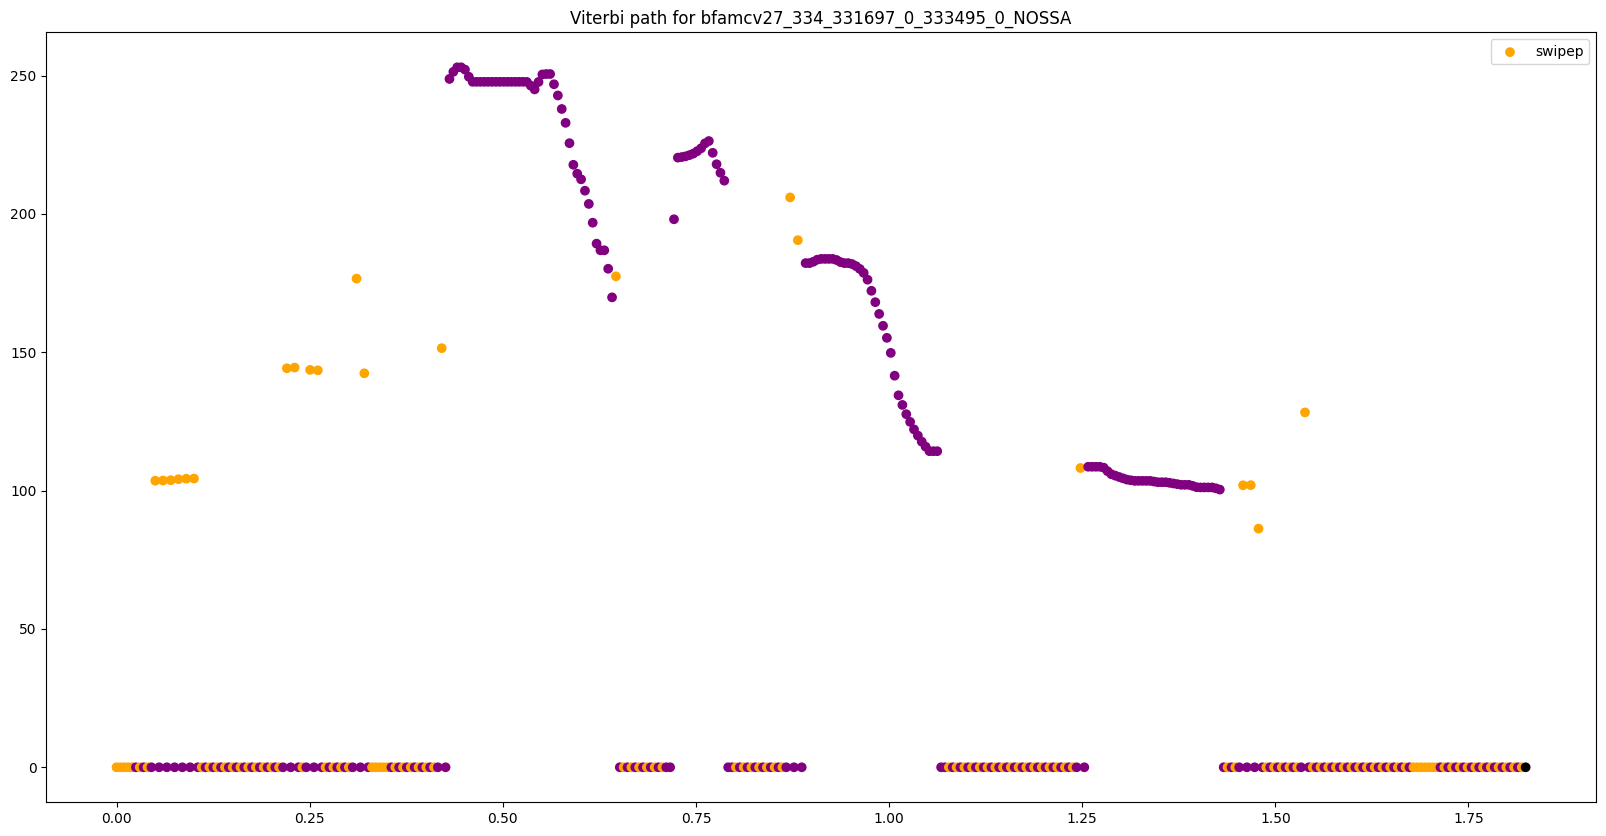

In [24]:
# Lets plot the results taking timeframes and unvoiced_viterbi_path as x and y axis
plt.figure(figsize=(20, 10))

# We want to color code points by the winning path
# We can use the index_dict to have the name of the winning algorithm


""" 
# Select PDAs to be tested
pdas = ['bana', 'praat_ac', 'pefac', 'straight', 'swipep', 'yaapt']
"""

colors_dict = {0: ['bana', 'black'],
                1: ['praat_ac', 'red'],
                2: ['pefac', 'blue'],
                3: ['straight', 'green'],
                4: ['swipep', 'orange'],
                5: ['yaapt', 'purple']}

# Create a list of colors for each point
colors = []
algo_name = []
for i in range(len(data)):
    colors.append(colors_dict[data['winning_path'][i]][1])
    algo_name.append(colors_dict[data['winning_path'][i]][0])

# We plot the scatterplot
plt.scatter(data['timeframes'], data['unvoiced_viterbi_path'], c=colors)

# Add legend
plt.legend(algo_name)

# Add title
plt.title('Viterbi path for bfamcv27_334_331697_0_333495_0_NOSSA')

# Show
plt.show()

In [25]:
# I want to create a smoothing function that takes the unvoiced_viterbi_path and returns a smoothed version of it, getting rid of very deviant values

# We will use the data in the dictionary to plot the results
import numpy as np
from scipy.signal import savgol_filter

def smooth_fundamental_frequency(x, y, window_size=7, poly_order=3, deviation_factor=2.0):
    """
    Smooths fundamental frequency data using a sliding window and zeroing out deviant points.

    Parameters:
    - x: array-like, time data
    - y: array-like, fundamental frequency data
    - window_size: int, size of the sliding window for smoothing
    - poly_order: int, order of the polynomial for Savitzky-Golay filter
    - deviation_factor: float, factor for determining deviant points to be zeroed out

    Returns:
    - smoothed_y: array, smoothed fundamental frequency data
    """

    # Apply Savitzky-Golay filter for initial smoothing
    smoothed_y = savgol_filter(y, window_size, poly_order)

    # Identify points deviating too much from the continuous curve
    deviant_points = np.abs(y - smoothed_y) > deviation_factor

    # Zero out deviant points
    smoothed_y[deviant_points] = 0

    return smoothed_y

# Example usage:
# Assuming you have time and fundamental frequency data
time_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
frequency_data = np.array([440, 445, 450, 200, 445, 450, 445, 440, 435, 440])

# Call the smoothing function
smoothed_frequency = smooth_fundamental_frequency(time_data, frequency_data)

# Print the results
print("Original Frequency Data:", frequency_data)
print("Smoothed Frequency Data:", smoothed_frequency)


Original Frequency Data: [440 445 450 200 445 450 445 440 435 440]
Smoothed Frequency Data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


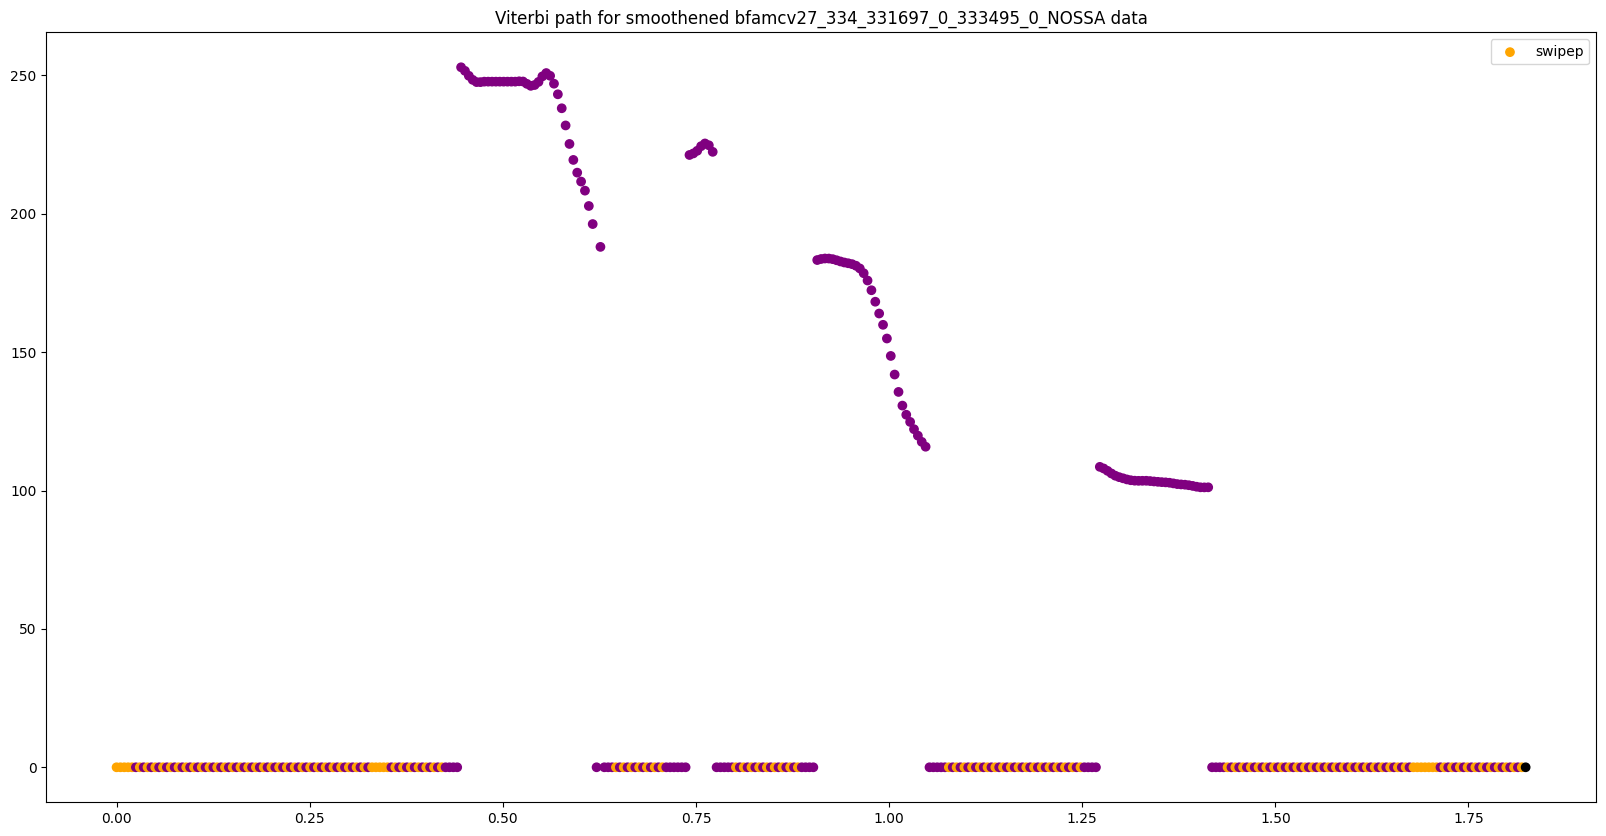

In [26]:
# We do the same plot but using the smoothed data
plt.figure(figsize=(20, 10))

# We want to color code points by the winning path
# We can use the index_dict to have the name of the winning algorithm


"""
# Select PDAs to be tested
pdas = ['bana', 'praat_ac', 'pefac', 'straight', 'swipep', 'yaapt']
"""

colors_dict = {0: ['bana', 'black'],
                1: ['praat_ac', 'red'],
                2: ['pefac', 'blue'],
                3: ['straight', 'green'],
                4: ['swipep', 'orange'],
                5: ['yaapt', 'purple']}
# Create a list of colors for each point
colors = []
algo_name = []
for i in range(len(data)):
    colors.append(colors_dict[data['winning_path'][i]][1])
    algo_name.append(colors_dict[data['winning_path'][i]][0])

# Smoothen the fundamental frequency data
smoothed_frequency = smooth_fundamental_frequency(data['timeframes'], data['unvoiced_viterbi_path'])

# We plot the scatterplot
plt.scatter(data['timeframes'], smoothed_frequency, c=colors)

# Add legend
plt.legend(algo_name)

# Add title
plt.title('Viterbi path for smoothened bfamcv27_334_331697_0_333495_0_NOSSA data')

# Show
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for Algorithm bana
No data for Algorithm praat_ac
No data for Algorithm pefac
No data for Algorithm straight
No data for Algorithm swipep
No data for Algorithm yaapt


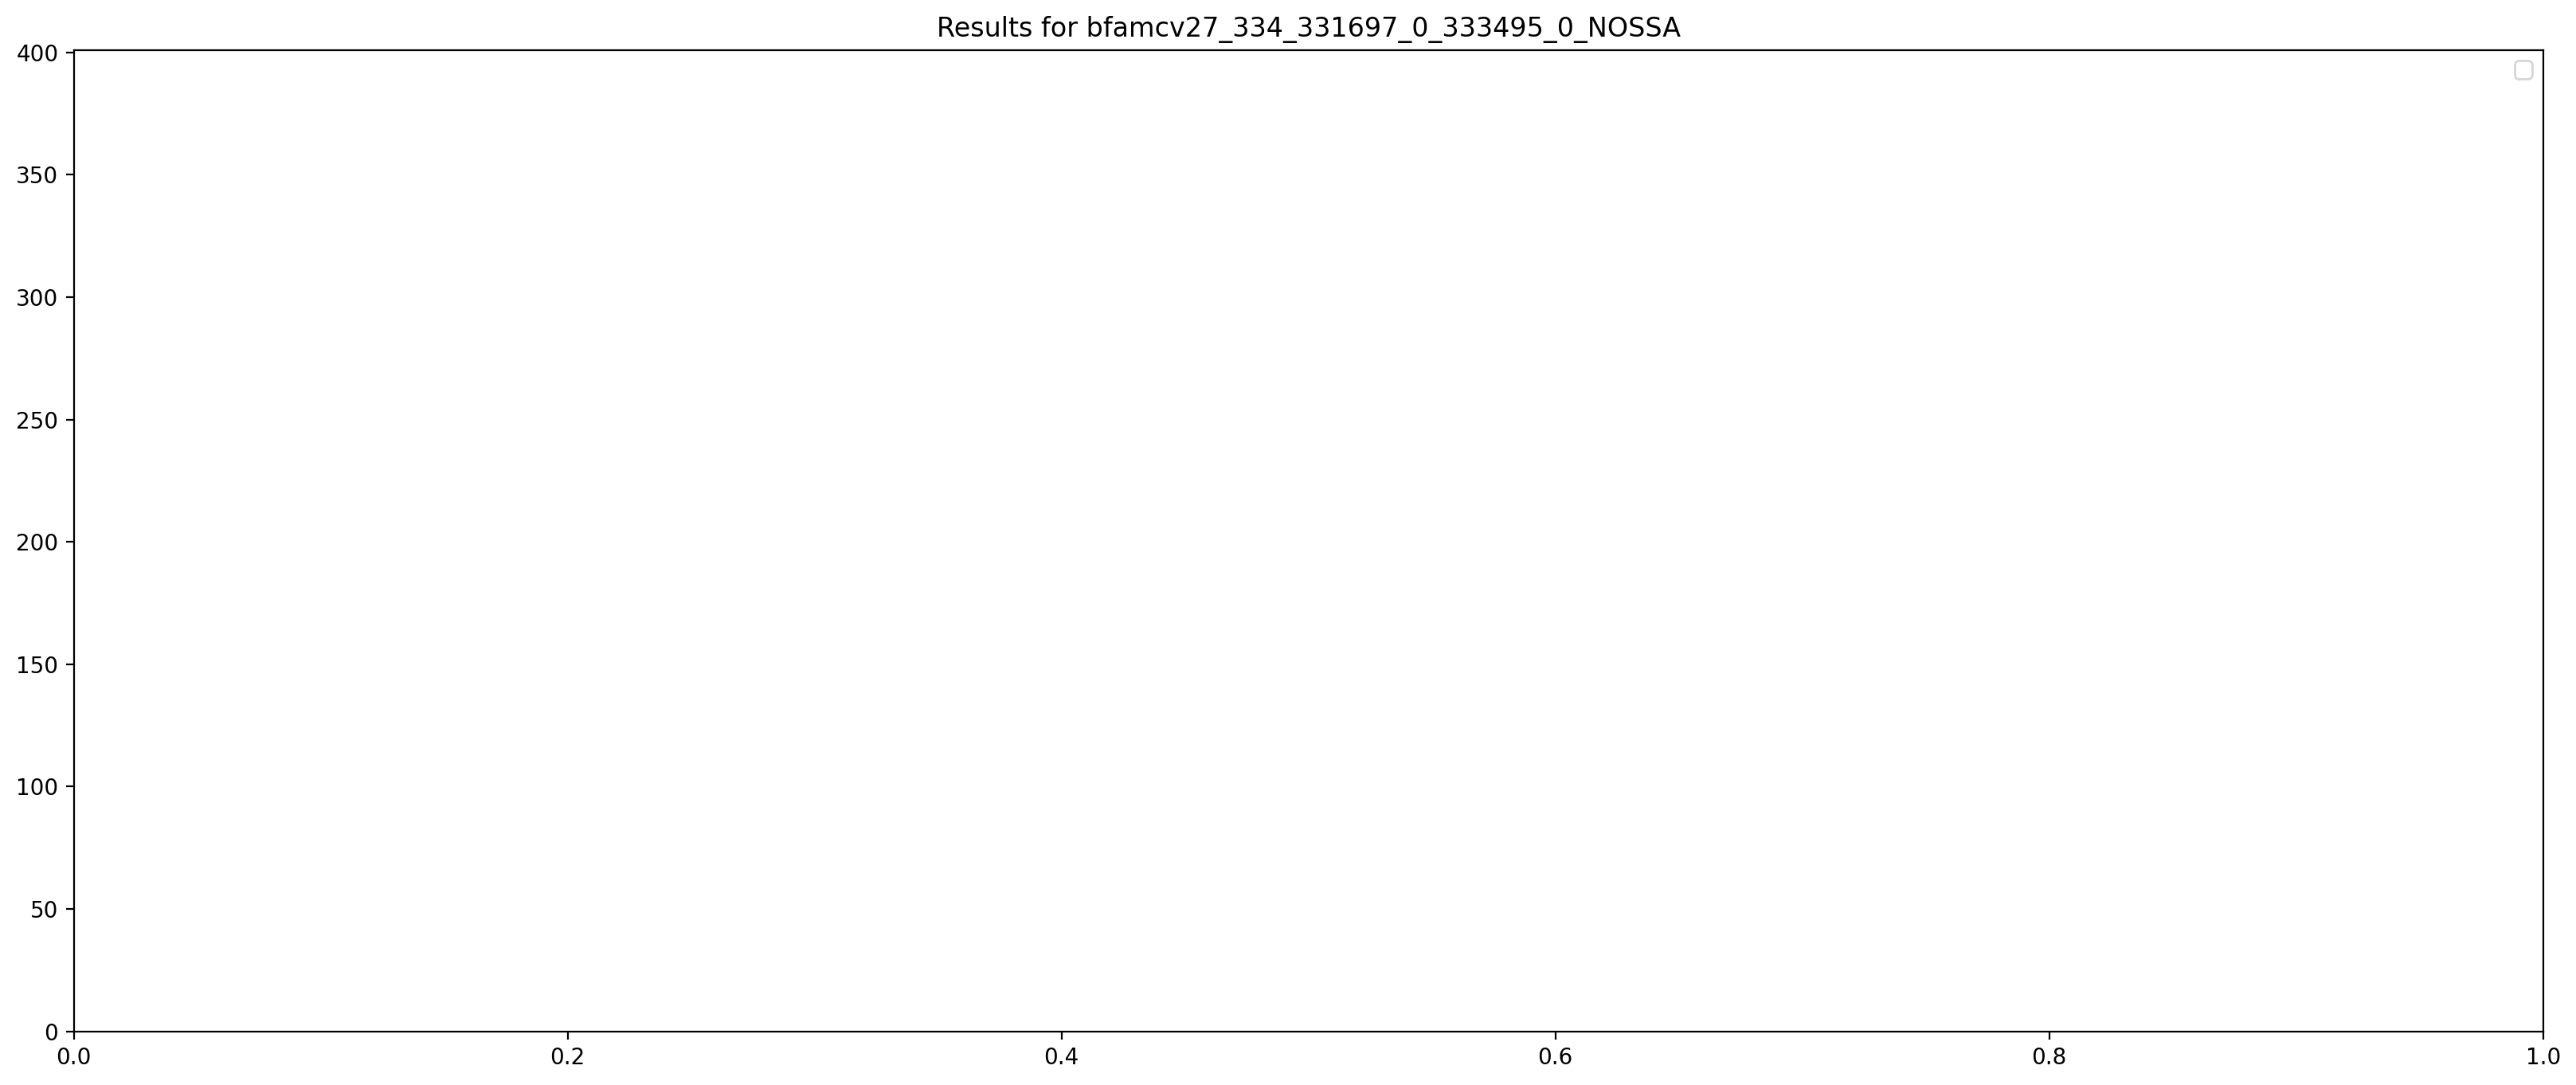

In [18]:
import matplotlib.pyplot as plt

# Get the data for bfamcv27_334_331697_0_333495_0_NOSSA
data = observations_dict['bfamcv27_334_331697_0_333495_0_NOSSA']
#data = observations_dict['bpubmn01__041__SHE']

# Create a figure with specified size and dpi
plt.figure(figsize=(20, 8), dpi=200)

# Replace 'smoothed_frequency' with the actual column name
data['smoothed_frequency'] = smooth_fundamental_frequency(data['timeframes'], data['unvoiced_viterbi_path'])

# Adjust ylim to 20% more than max point in the data
y_max = data['smoothed_frequency'].max() * 1.2
plt.ylim(0, y_max)

colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'gray', 5: 'purple'}
pdas = ['bana', 'praat_ac', 'pefac', 'straight', 'swipep', 'yaapt']

# Do pdas_dict inverted mapping
pdas_dict = {'0.0': 'bana', '1.0': 'praat_ac', '2.0': 'pefac', '3.0': 'straight', '4.0': 'swipep', '5.0': 'yaapt'}

# Map float values in 'winning_path' to PDA names
data['winning_algorithm'] = data['winning_path'].map(pdas_dict)

for algo in pdas:
    algo_data = data[data['winning_algorithm'] == algo]
    if not algo_data.empty:
        plt.scatter(
            algo_data['timeframes'],
            algo_data['smoothed_frequency'],
            label=algo,
            color=colors[pdas.index(algo)],
            marker='o'
        )
        print(f"Algorithm {algo} data count: {len(algo_data)}")
    else:
        print(f"No data for Algorithm {algo}")

plt.title("Results for bfamcv27_334_331697_0_333495_0_NOSSA")
plt.legend(loc="upper right", markerscale=0.7, scatterpoints=1, fontsize=10)

plt.show()


In [78]:
type(data['winning_path'].unique()[0])

str

In [76]:
data['winning_algorithm'].unique()

array([nan], dtype=object)

In [101]:
# Check type of data['winning_path']
type(data['winning_path'][0])

print(data['winning_path'][0])

1.0


In [97]:
data.head()

,timeframes,creaky_voice_decision,bana,opensmile,pefac,praat_ac,praat_cc,praat_shs,pyin,rapt,...,mfcc_20,group_index,model_pred_all,model_pred_mfcc,model_pred_f0,winning_path,winning_candidates,unvoiced_viterbi_path,smoothed_frequency,winning_algorithm
0,0.000000,0.0,0.0,62.046803,108.388689,88.234572,89.533232,86.884783,0.0,89.750989,...,2.935344,22.0,0.0,0.0,0.0,1.0,88.234572,0.000000,0.0,NaN
1,0.005003,0.0,0.0,62.046803,108.388689,88.234572,89.533232,86.884783,0.0,87.122973,...,2.855291,22.0,0.0,0.0,0.0,1.0,88.234572,0.000000,0.0,NaN
2,0.010006,0.0,0.0,62.046803,108.388689,88.234572,89.533232,86.884783,0.0,85.005773,...,2.799252,22.0,0.0,0.0,1.0,1.0,88.234572,0.000000,0.0,NaN
3,0.015009,0.0,0.0,62.046803,108.388689,88.234572,89.297536,86.884783,0.0,86.112743,...,2.828500,22.0,1.0,0.0,1.0,1.0,88.234572,88.234572,0.0,NaN
4,0.020012,0.0,0.0,62.046803,108.388689,88.234572,88.121377,86.884783,0.0,87.534027,...,2.772322,22.0,1.0,0.0,1.0,1.0,88.234572,88.234572,0.0,NaN


In [105]:
# Check winning_paths unique values

type(data['winning_path'].unique()[0])

str

In [99]:
data['winning_algorithm']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
685    NaN
686    NaN
687    NaN
688    NaN
689    NaN
Name: winning_algorithm, Length: 690, dtype: object

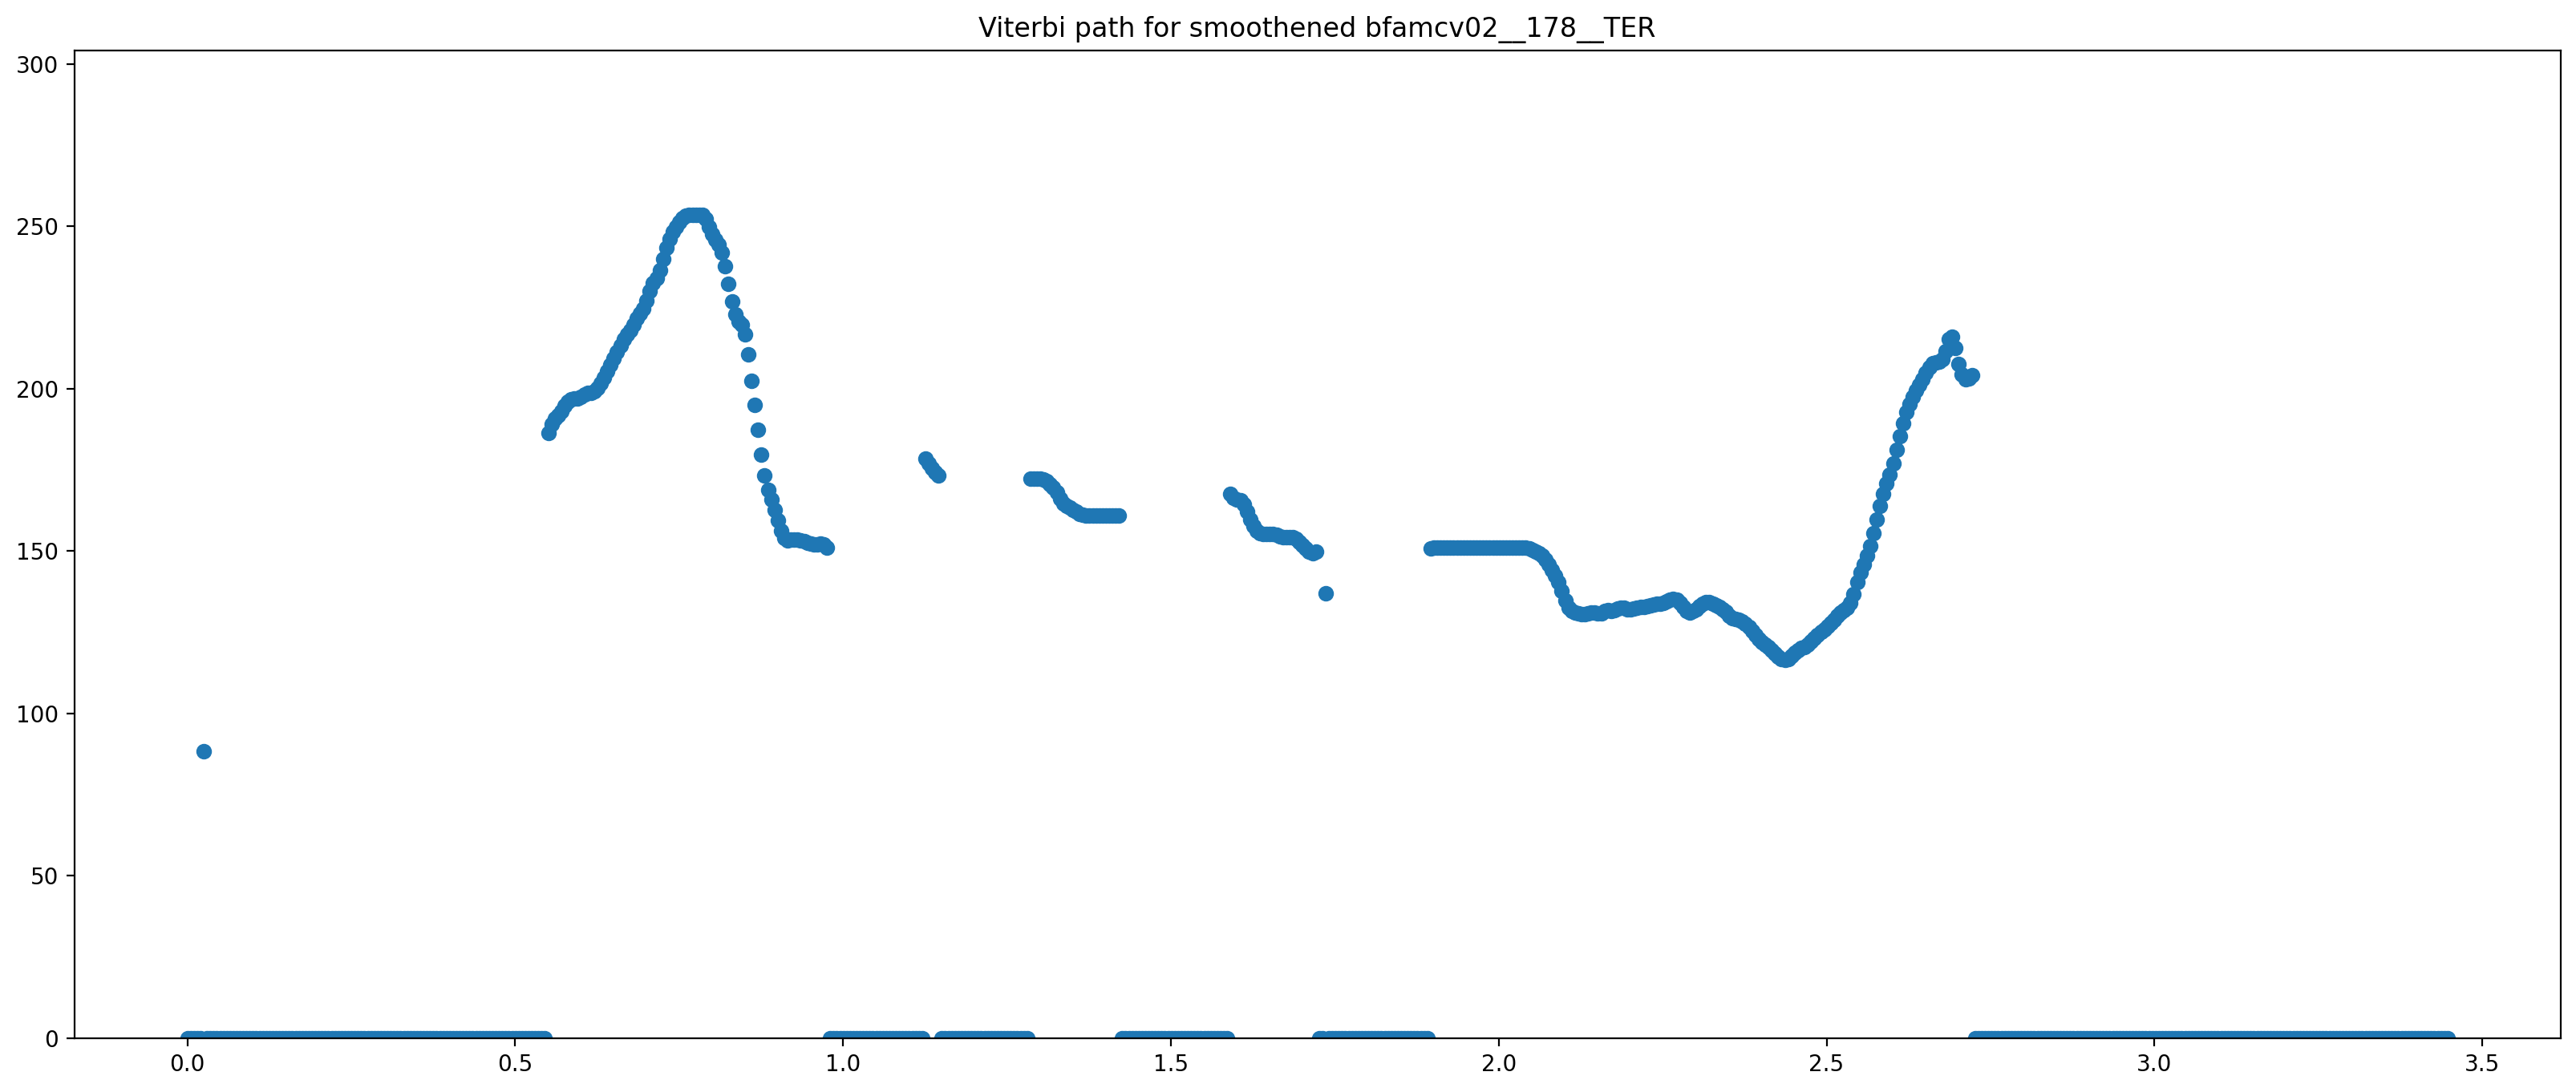

In [106]:
# Lets just plot the unvoiced_viterbi_path for the file with smoothing
# Get the data for bpubmn01__024__SHE
file = 'bfamcv02__178__TER'

data = observations_dict[file]

# Create a figure with specified size and dpi
plt.figure(figsize=(20, 8), dpi=200)

# Replace 'smoothed_frequency' with the actual column name
data['smoothed_frequency'] = smooth_fundamental_frequency(data['timeframes'], data['unvoiced_viterbi_path'])

# Adjust ylim to 20% more than max point in the data
y_max = data['smoothed_frequency'].max() * 1.2
plt.ylim(0, y_max)

# We plot the scatterplot
plt.scatter(data['timeframes'], data['smoothed_frequency'])

# Add title
plt.title('Viterbi path for smoothened {}'.format(file))

# Show
plt.show()

Unique values in 'winning_algorithm': ['praat_ac' 'swipep' 'yaapt' 'bana']
Algorithm bana data count: 1
Algorithm praat_ac data count: 7
No data for Algorithm pefac
No data for Algorithm straight
Algorithm swipep data count: 191
Algorithm yaapt data count: 491


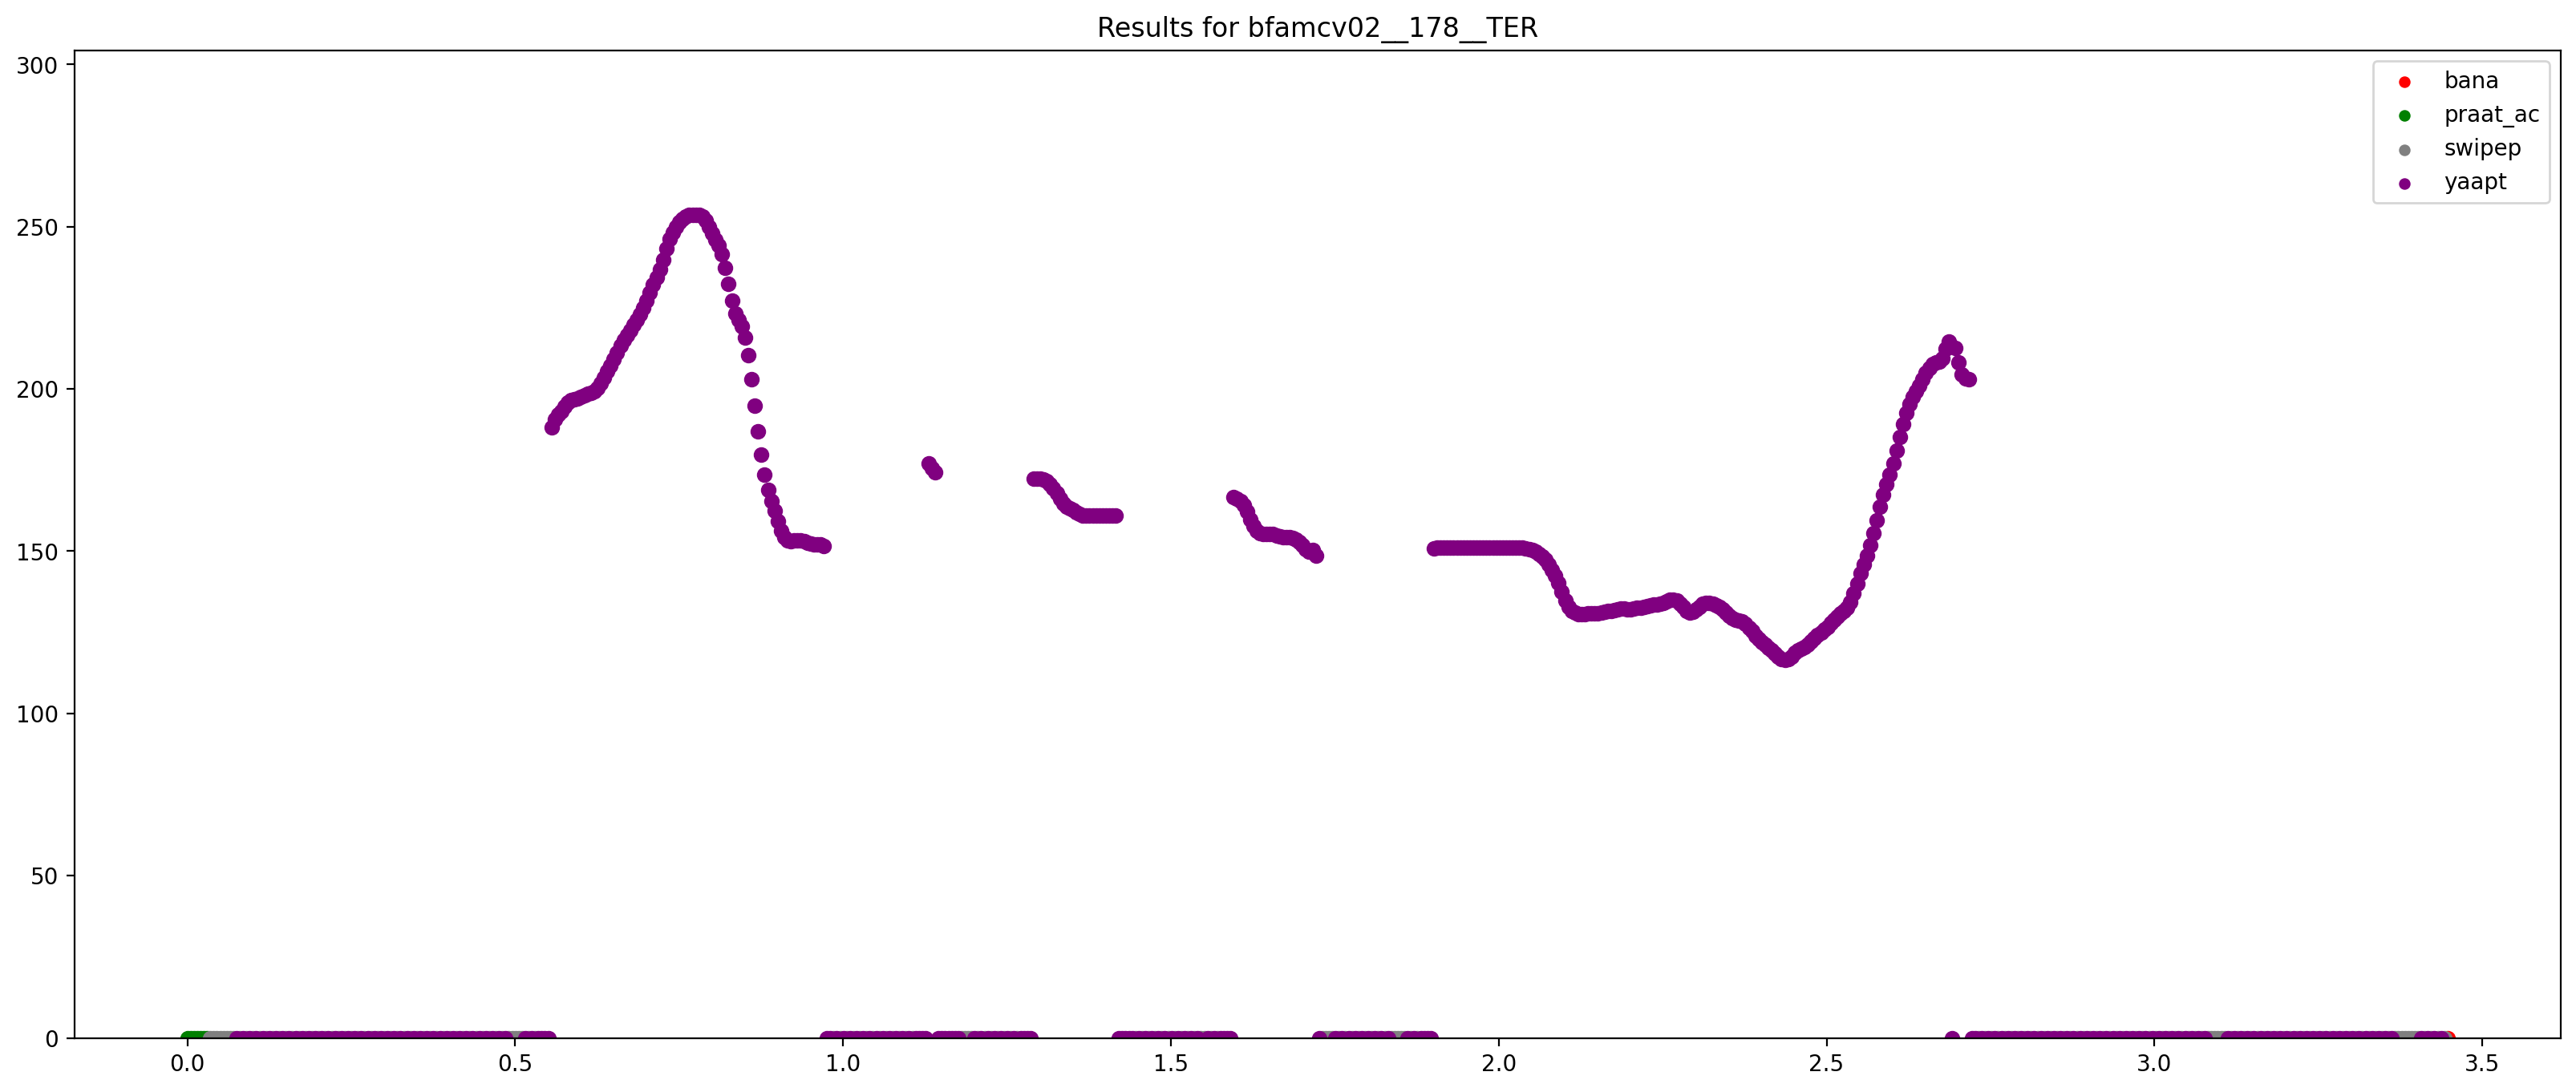

In [116]:
import matplotlib.pyplot as plt

# Get the data for bpubmn01__024__SHE
file = 'bfamcv02__178__TER'
data = observations_dict[file]

# Create a figure with specified size and dpi
plt.figure(figsize=(20, 8), dpi=200)

# Replace 'smoothed_frequency' with the actual column name
data['smoothed_frequency'] = smooth_fundamental_frequency(data['timeframes'], data['unvoiced_viterbi_path'])

# Adjust ylim to 20% more than max point in the data
y_max = data['smoothed_frequency'].max() * 1.2
plt.ylim(0, y_max)

colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'gray', 5: 'purple'}
pdas = ['bana', 'praat_ac', 'pefac', 'straight', 'swipep', 'yaapt']

# Transform 'winning_path' to string
data['winning_path'] = data['winning_path'].astype(str)

# Do pdas_dict inverted mapping
pdas_dict = {'0.0': 'bana', '1.0': 'praat_ac', '2.0': 'pefac', '3.0': 'straight', '4.0': 'swipep', '5.0': 'yaapt'}

# Map float values in 'winning_path' to PDA names
data['winning_algorithm'] = data['winning_path'].map(pdas_dict)

# Print unique values in 'winning_algorithm'
print("Unique values in 'winning_algorithm':", data['winning_algorithm'].unique())

for algo in pdas:
    # Get the data for the current algorithm
    algo_data = data[data['winning_algorithm'] == algo]
    if not algo_data.empty:
        plt.scatter(
            algo_data['timeframes'],
            algo_data['smoothed_frequency'],
            label=algo,
            color=colors[pdas.index(algo)],
            marker='o'
        )
        print(f"Algorithm {algo} data count: {len(algo_data)}")
    else:
        print(f"No data for Algorithm {algo}")

plt.title("Results for {}".format(file))
plt.legend(loc="upper right", markerscale=0.7, scatterpoints=1, fontsize=10)

plt.show()


Unique values in 'winning_algorithm': ['swipep' 'yaapt' 'bana']
Algorithm bana data count: 1
No data for Algorithm praat_ac
No data for Algorithm pefac
No data for Algorithm straight
Algorithm swipep data count: 105
Algorithm yaapt data count: 175


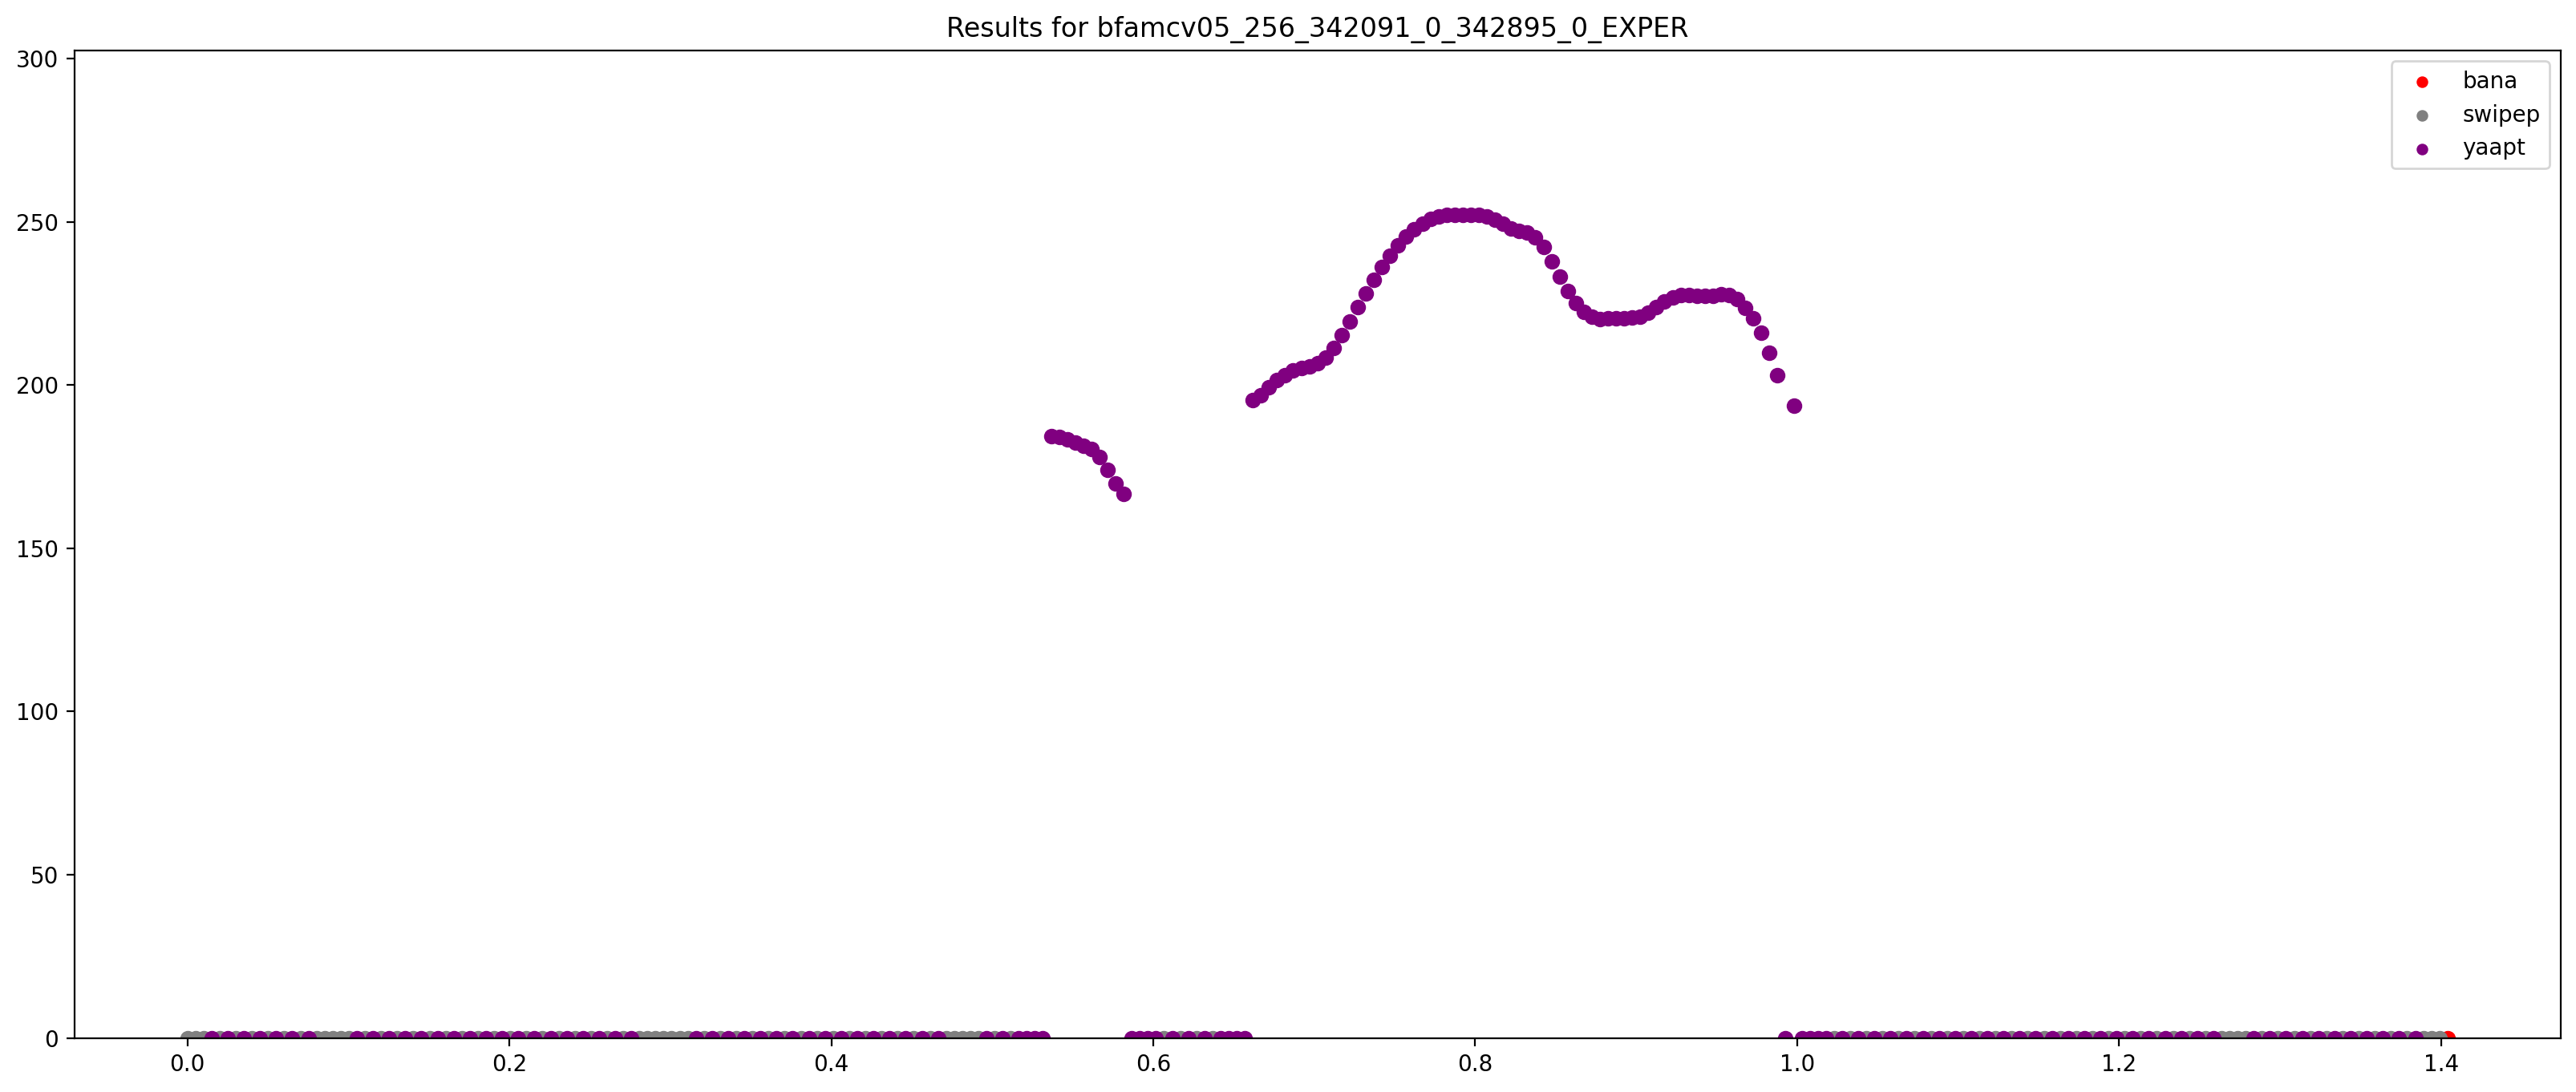

In [117]:
import matplotlib.pyplot as plt

# Get the data for bpubmn01__024__SHE
file = 'bfamcv05_256_342091_0_342895_0_EXPER'
data = observations_dict[file]

# Create a figure with specified size and dpi
plt.figure(figsize=(20, 8), dpi=200)

# Replace 'smoothed_frequency' with the actual column name
data['smoothed_frequency'] = smooth_fundamental_frequency(data['timeframes'], data['unvoiced_viterbi_path'])

# Adjust ylim to 20% more than max point in the data
y_max = data['smoothed_frequency'].max() * 1.2
plt.ylim(0, y_max)

colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'gray', 5: 'purple'}
pdas = ['bana', 'praat_ac', 'pefac', 'straight', 'swipep', 'yaapt']

# Transform 'winning_path' to string
data['winning_path'] = data['winning_path'].astype(str)

# Do pdas_dict inverted mapping
pdas_dict = {'0.0': 'bana', '1.0': 'praat_ac', '2.0': 'pefac', '3.0': 'straight', '4.0': 'swipep', '5.0': 'yaapt'}

# Map float values in 'winning_path' to PDA names
data['winning_algorithm'] = data['winning_path'].map(pdas_dict)

# Print unique values in 'winning_algorithm'
print("Unique values in 'winning_algorithm':", data['winning_algorithm'].unique())

for algo in pdas:
    # Get the data for the current algorithm
    algo_data = data[data['winning_algorithm'] == algo]
    if not algo_data.empty:
        plt.scatter(
            algo_data['timeframes'],
            algo_data['smoothed_frequency'],
            label=algo,
            color=colors[pdas.index(algo)],
            marker='o'
        )
        print(f"Algorithm {algo} data count: {len(algo_data)}")
    else:
        print(f"No data for Algorithm {algo}")

plt.title("Results for {}".format(file))
plt.legend(loc="upper right", markerscale=0.7, scatterpoints=1, fontsize=10)

plt.show()


Unique values in 'winning_algorithm': ['swipep' 'yaapt' 'bana']
Algorithm bana data count: 1
No data for Algorithm praat_ac
No data for Algorithm pefac
No data for Algorithm straight
Algorithm swipep data count: 151
Algorithm yaapt data count: 956


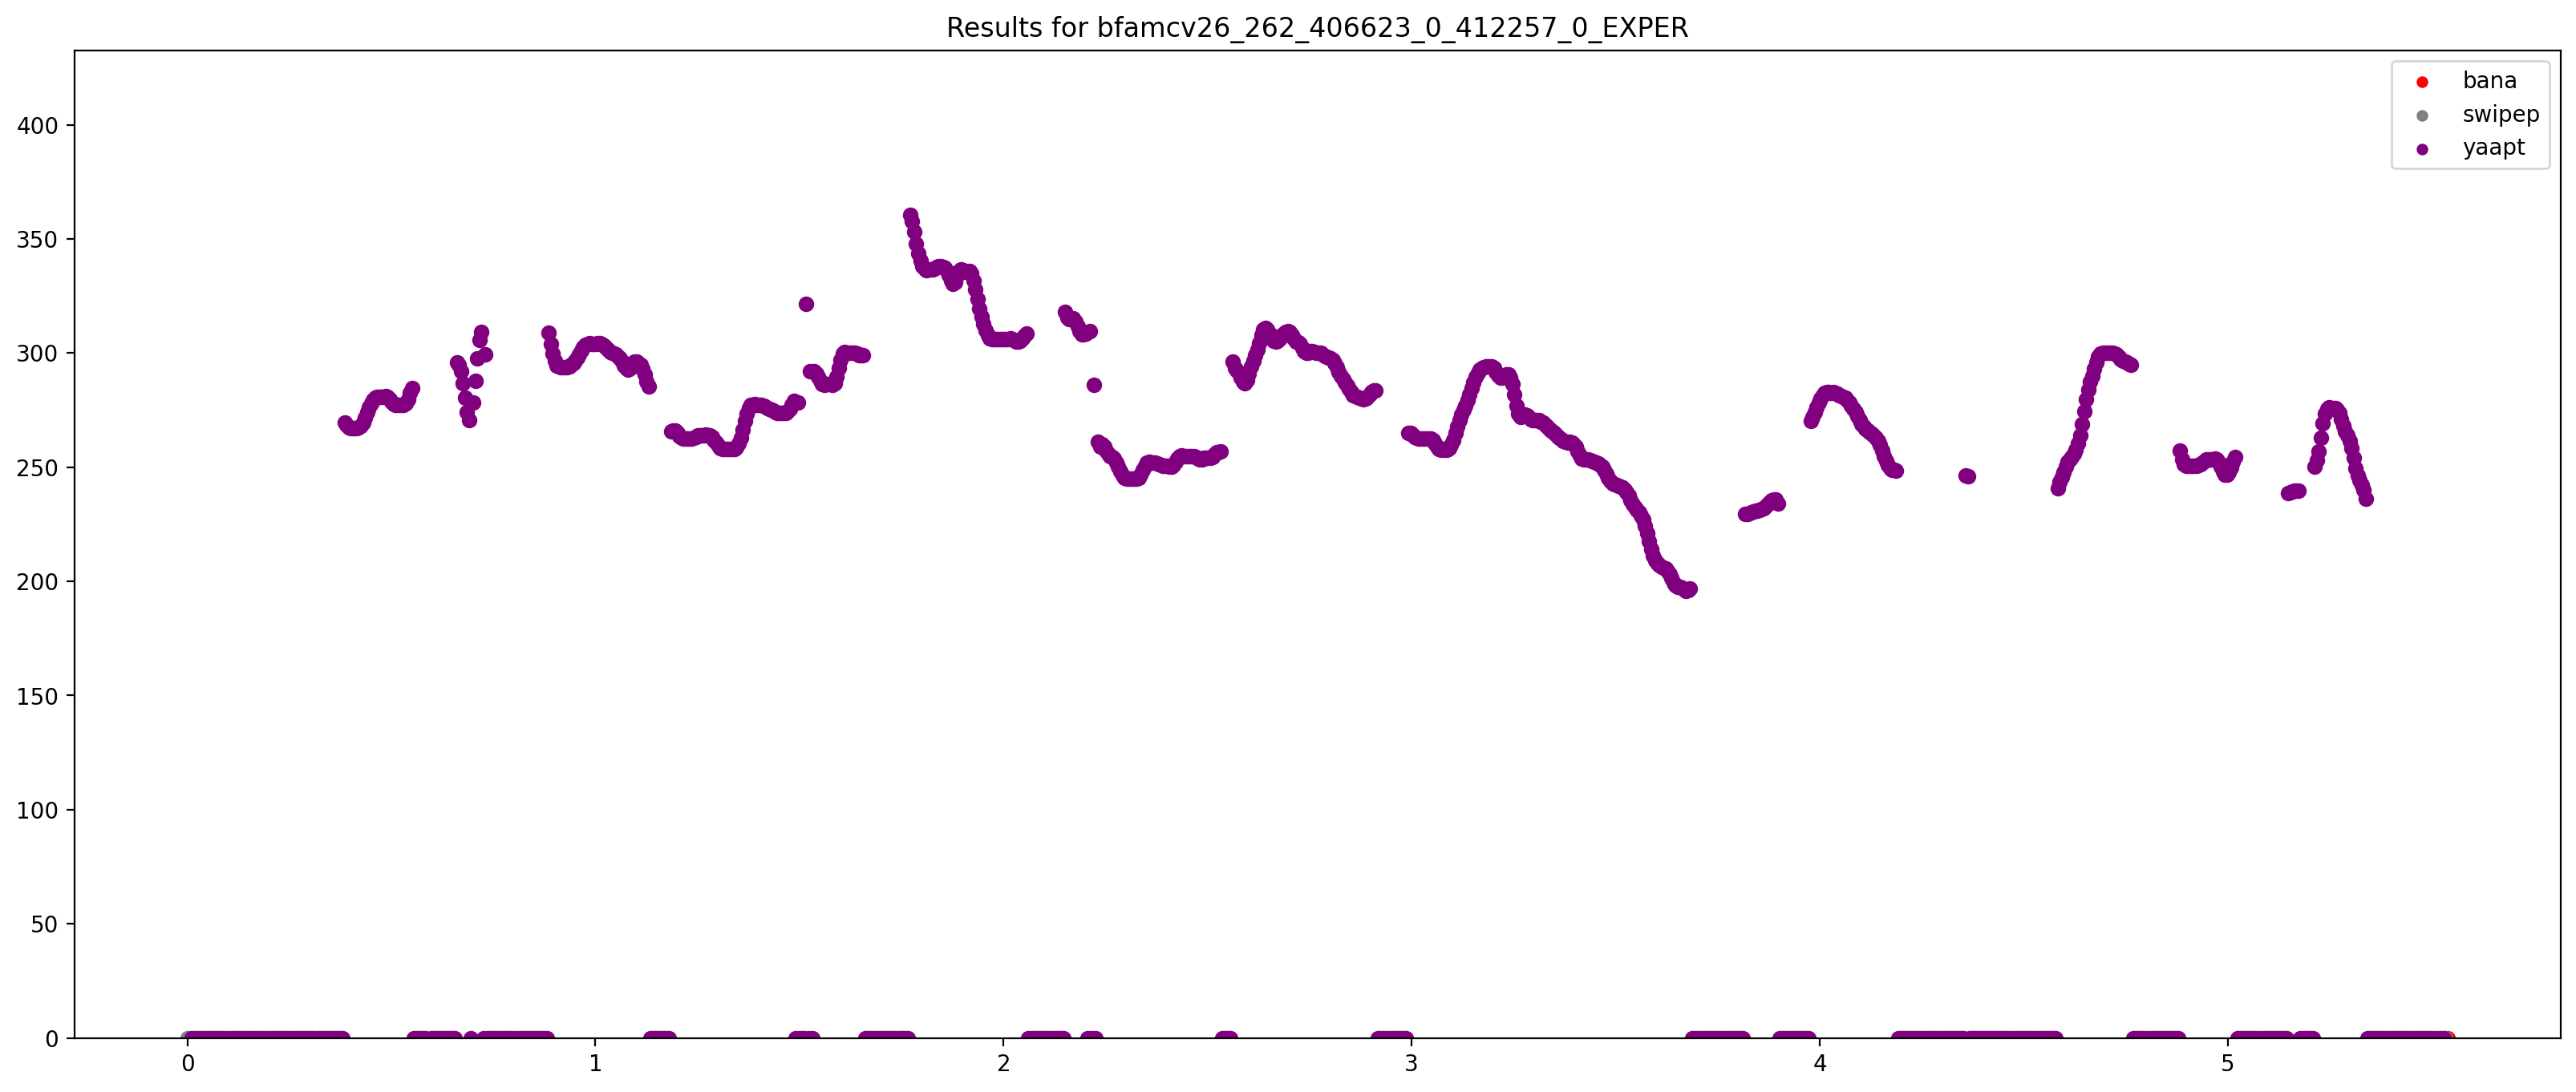

In [118]:
import matplotlib.pyplot as plt

# Get the data for bpubmn01__024__SHE
file = 'bfamcv26_262_406623_0_412257_0_EXPER'
data = observations_dict[file]

# Create a figure with specified size and dpi
plt.figure(figsize=(20, 8), dpi=200)

# Replace 'smoothed_frequency' with the actual column name
data['smoothed_frequency'] = smooth_fundamental_frequency(data['timeframes'], data['unvoiced_viterbi_path'])

# Adjust ylim to 20% more than max point in the data
y_max = data['smoothed_frequency'].max() * 1.2
plt.ylim(0, y_max)

colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'gray', 5: 'purple'}
pdas = ['bana', 'praat_ac', 'pefac', 'straight', 'swipep', 'yaapt']

# Transform 'winning_path' to string
data['winning_path'] = data['winning_path'].astype(str)

# Do pdas_dict inverted mapping
pdas_dict = {'0.0': 'bana', '1.0': 'praat_ac', '2.0': 'pefac', '3.0': 'straight', '4.0': 'swipep', '5.0': 'yaapt'}

# Map float values in 'winning_path' to PDA names
data['winning_algorithm'] = data['winning_path'].map(pdas_dict)

# Print unique values in 'winning_algorithm'
print("Unique values in 'winning_algorithm':", data['winning_algorithm'].unique())

for algo in pdas:
    # Get the data for the current algorithm
    algo_data = data[data['winning_algorithm'] == algo]
    if not algo_data.empty:
        plt.scatter(
            algo_data['timeframes'],
            algo_data['smoothed_frequency'],
            label=algo,
            color=colors[pdas.index(algo)],
            marker='o'
        )
        print(f"Algorithm {algo} data count: {len(algo_data)}")
    else:
        print(f"No data for Algorithm {algo}")

plt.title("Results for {}".format(file))
plt.legend(loc="upper right", markerscale=0.7, scatterpoints=1, fontsize=10)

plt.show()

In [119]:
data.head()

,timeframes,creaky_voice_decision,bana,opensmile,pefac,praat_ac,praat_cc,praat_shs,pyin,rapt,...,mfcc_20,group_index,model_pred_all,model_pred_mfcc,model_pred_f0,winning_path,winning_candidates,unvoiced_viterbi_path,smoothed_frequency,winning_algorithm
0,0.000000,0.0,0.000000,61.417389,299.385693,0.0,290.433301,0.0,0.0,290.771765,...,-3.242441,127.0,0.0,0.0,0.0,4.0,605.221190,0.0,0.0,swipep
1,0.005003,0.0,0.000000,61.417389,299.385693,0.0,290.433301,0.0,0.0,568.904688,...,-3.397510,127.0,0.0,0.0,0.0,4.0,608.024378,0.0,0.0,swipep
2,0.010006,0.0,292.939963,61.417389,299.385693,0.0,290.433301,0.0,0.0,336.689262,...,-3.823028,127.0,0.0,0.0,0.0,5.0,0.000000,0.0,0.0,yaapt
3,0.015008,0.0,295.984793,61.417389,299.385693,0.0,290.685855,0.0,0.0,277.971478,...,-4.521550,127.0,0.0,0.0,0.0,4.0,289.780899,0.0,0.0,swipep
4,0.020011,0.0,290.447365,61.417389,299.385693,0.0,0.000000,0.0,0.0,137.466066,...,-5.538280,127.0,0.0,0.0,0.0,5.0,0.000000,0.0,0.0,yaapt
